In [1]:
import scipy as sp
import numpy as np
import time

import matplotlib.pyplot as plt

try:
    from localgraphclustering import *
except:
    # when the package is not installed, import the local version instead. 
    # the notebook must be placed in the original "notebooks/" folder
    sys.path.append("../")
    from localgraphclustering import * 

import time

import networkx as nx

import random

import statistics as stat_

import sys,os

## Load data

In [2]:
data_path = os.getcwd()
name = '../datasets/com-orkut.ungraph.edgelist'
g = GraphLocal(os.path.join(data_path,name),'edgelist', "	")

## TEMP

In [3]:
comm_name = '../datasets/com-orkut.top5000.cmty.txt'
ground_truth_clusters = []
with open(comm_name, "r") as f:
    for line in f:
        new_line = []
        for i in line.split():
            if i.isdigit():
                new_line.append(int(i))
        ground_truth_clusters.append(new_line)

In [4]:
all_clusters = []

some_data = np.zeros((282,1))
    
counter = 0
ct = 0 
for cluster in ground_truth_clusters:
    
    if len(cluster) == 1 or len(cluster) == 0:
        counter += 1
        continue
    
#     eig, lambda_ = fiedler_local(g, cluster)
#     lambda_ = np.real(lambda_)
#     gap = lambda_/g.compute_conductance(cluster)
    cond = g.compute_conductance(cluster)
    counter += 1
    
    if cond <= 0.6 and len(cluster) >= 10:
        print("Cluster: ", counter, " conductance: ", cond, "Size: ", len(cluster))
        all_clusters.append(cluster)
        some_data[ct,0] = cond
        ct += 1

Cluster:  5  conductance:  0.11285574092247301 Size:  55
Cluster:  19  conductance:  0.5906287069988138 Size:  415
Cluster:  31  conductance:  0.5863862027397839 Size:  4632
Cluster:  61  conductance:  0.5187786485287594 Size:  391
Cluster:  70  conductance:  0.569192114418245 Size:  287
Cluster:  102  conductance:  0.596409806609839 Size:  929
Cluster:  114  conductance:  0.5897387993065419 Size:  4575
Cluster:  121  conductance:  0.5679066696015849 Size:  263
Cluster:  145  conductance:  0.5481889430205465 Size:  343
Cluster:  147  conductance:  0.5980310475575128 Size:  1149
Cluster:  149  conductance:  0.5856494815668203 Size:  688
Cluster:  160  conductance:  0.5641021394430624 Size:  2026
Cluster:  163  conductance:  0.5992874554659666 Size:  934
Cluster:  190  conductance:  0.5972854423570305 Size:  229
Cluster:  192  conductance:  0.5941597910146652 Size:  831
Cluster:  196  conductance:  0.5542462265866521 Size:  320
Cluster:  213  conductance:  0.5850319050011222 Size:  1419


Cluster:  2135  conductance:  0.5129474652762565 Size:  233
Cluster:  2146  conductance:  0.5644690333487014 Size:  80
Cluster:  2235  conductance:  0.5767158992180712 Size:  160
Cluster:  2242  conductance:  0.4230769230769231 Size:  10
Cluster:  2257  conductance:  0.586218836565097 Size:  75
Cluster:  2269  conductance:  0.5512901935878437 Size:  318
Cluster:  2290  conductance:  0.5486961149547632 Size:  64
Cluster:  2296  conductance:  0.4519230769230769 Size:  22
Cluster:  2305  conductance:  0.5576078728236185 Size:  87
Cluster:  2320  conductance:  0.5657894736842105 Size:  65
Cluster:  2351  conductance:  0.46830117510517916 Size:  128
Cluster:  2358  conductance:  0.5939972080037227 Size:  208
Cluster:  2374  conductance:  0.5099283520982599 Size:  56
Cluster:  2400  conductance:  0.5486272684969753 Size:  63
Cluster:  2411  conductance:  0.5808314087759815 Size:  90
Cluster:  2417  conductance:  0.5940315315315315 Size:  49
Cluster:  2438  conductance:  0.5668062158518413 Si

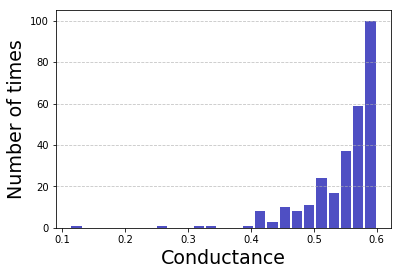

In [5]:
fig = plt.figure()
plt.hist(some_data, bins=25, color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.ylabel('Number of times', fontsize=19)
plt.xlabel('Conductance', fontsize=19)
plt.grid(axis='y', alpha=0.75, linestyle='--')
plt.show()

fig.savefig('histogram_orkut.pdf')

## Collect data for ACL (with rounding)

In [ ]:
nodes = {}
external_best_cond_acl = {}
external_best_pre_cond_acl = {}
vol_best_cond_acl = {}
vol_best_pre_acl = {}
size_clust_best_cond_acl = {}
size_clust_best_pre_acl = {}
f1score_best_cond_acl = {}
f1score_best_pre_acl = {}
true_positives_best_cond_acl = {}
true_positives_best_pre_acl = {}
precision_best_cond_acl = {}
precision_best_pre_acl = {}
recall_best_cond_acl = {}
recall_best_pre_acl = {}
cuts_best_cond_acl = {}
cuts_best_pre_acl = {}
cuts_acl_ALL = {}

ct_outer = 0

number_experiments = 0

for rr in all_clusters:
    
    how_many = int(len(rr))
    print(how_many)
    
    random.seed(4)
    
    nodes[ct_outer] = np.random.choice(rr, how_many, replace=False)
    
    eigv, lambda_val = fiedler_local(g, rr)
    lambda_val = np.real(lambda_val)
    
    step = (2*lambda_val - lambda_val/2)/4
    
    a_list = np.arange(lambda_val/2,2*lambda_val,step)
    
    ct = 0
    
    start = time.time()
    
    for node in nodes[ct_outer]:
        ref_node = [node]
        
        max_precision = -1
        min_conduct = 100
        
        ct_inner = 0
        for a in a_list:
            
            if ct_outer <= 1:
                rho = 0.15/np.sum(g.d[rr])
            else:
                rho = 0.2/np.sum(g.d[rr])
            
            output_pr_clustering = approximate_PageRank(g,ref_node,method = "acl", rho=rho, alpha=a, cpp = True, normalize=True,normalized_objective=True)
            number_experiments += 1
            
            output_pr_sc = sweep_cut(g,output_pr_clustering,cpp=True)
            
            S = output_pr_sc[0]
            
#             cuts_acl_ALL[ct_outer,node,ct_inner] = S
            
            size_clust_acl_ = len(S)
            
            cond_val_l1pr = g.compute_conductance(S)
            
            vol_ = sum(g.d[S])
            true_positives_acl_ = set(rr).intersection(S)
            if len(true_positives_acl_) == 0:
                true_positives_acl_ = set(ref_node)
                vol_ = g.d[ref_node][0,0]
            precision = sum(g.d[np.array(list(true_positives_acl_))])/vol_
            recall = sum(g.d[np.array(list(true_positives_acl_))])/sum(g.d[rr])
            f1_score_ = 2*(precision*recall)/(precision + recall)
            
            if f1_score_ >= max_precision:
                
                max_precision = f1_score_
                
                external_best_pre_cond_acl[ct_outer,node] = cond_val_l1pr
                vol_best_pre_acl[ct_outer,node] = vol_
                
                size_clust_best_pre_acl[ct_outer,node] = size_clust_acl_
                true_positives_best_pre_acl[ct_outer,node] = true_positives_acl_
                precision_best_pre_acl[ct_outer,node] = precision
                recall_best_pre_acl[ct_outer,node] = recall
                f1score_best_pre_acl[ct_outer,node] = f1_score_
                
                cuts_best_pre_acl[ct_outer,node] = S
        
            if cond_val_l1pr <= min_conduct:
                
                min_conduct = cond_val_l1pr
                
                external_best_cond_acl[ct_outer,node] = cond_val_l1pr
                vol_best_cond_acl[ct_outer,node] = vol_
                
                size_clust_best_cond_acl[ct_outer,node] = size_clust_acl_
                true_positives_best_cond_acl[ct_outer,node] = true_positives_acl_
                precision_best_cond_acl[ct_outer,node] = precision
                recall_best_cond_acl[ct_outer,node] = recall
                f1score_best_cond_acl[ct_outer,node] = f1_score_
                
                cuts_best_cond_acl[ct_outer,node] = S

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', external_best_cond_acl[ct_outer,node], 'f1score: ', f1score_best_cond_acl[ct_outer,node], 'precision: ', precision_best_cond_acl[ct_outer,node], 'recall: ', recall_best_cond_acl[ct_outer,node])
        ct += 1
    end = time.time()
    print(" ")
    print("Outer: ", ct_outer," Elapsed time ACL with rounding: ", end - start)
    print("Outer: ", ct_outer," Number of experiments: ", number_experiments)
    print(" ")
    ct_outer += 1

## Performance of ACL (with rounding).

In [ ]:
all_data = []
xlabels_ = []

print('Results for ACL with rounding')
sum_precision = 0
sum_recall = 0
sum_f1 = 0
sum_conductance = 0

info_ref_nodes = all_clusters
l_info_ref_nodes = len(info_ref_nodes)

for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    temp_conductance = []
    
    for j in all_clusters[i]:
        temp_pre.append(precision_best_cond_acl[i,j])
        temp_rec.append(recall_best_cond_acl[i,j])
        temp_f1.append(f1score_best_cond_acl[i,j])
        temp_conductance.append(external_best_cond_acl[i,j])
    
    print('Feature:', i,'Precision', stat_.mean(temp_pre), 'Recall', stat_.mean(temp_rec), 'F1', stat_.mean(temp_f1), 'Cond.', stat_.mean(temp_conductance))

np.save('f1score_best_pre_acl_ORKUT', f1score_best_pre_acl) 
np.save('precision_best_pre_acl_ORKUT', precision_best_pre_acl) 
np.save('recall_best_pre_acl_ORKUT', recall_best_pre_acl) 

## Collect data for l1-reg. PR (with rounding)

In [ ]:
nodes = {}
external_best_cond_l1reg = {}
external_best_pre_cond_l1reg = {}
vol_best_cond_l1reg = {}
vol_best_pre_l1reg = {}
size_clust_best_cond_l1reg = {}
size_clust_best_pre_l1reg = {}
f1score_best_cond_l1reg = {}
f1score_best_pre_l1reg = {}
true_positives_best_cond_l1reg = {}
true_positives_best_pre_l1reg = {}
precision_best_cond_l1reg = {}
precision_best_pre_l1reg = {}
recall_best_cond_l1reg = {}
recall_best_pre_l1reg = {}
cuts_best_cond_l1reg = {}
cuts_best_pre_l1reg = {}
cuts_l1reg_ALL = {}

ct_outer = 0

number_experiments = 0

for rr in all_clusters:
    
    how_many = int(len(rr))
    print(how_many)
    
    random.seed(4)
    
    nodes[ct_outer] = np.random.choice(rr, how_many, replace=False)
    
    eigv, lambda_val = fiedler_local(g, rr)
    lambda_val = np.real(lambda_val)
    
    step = (2*lambda_val - lambda_val/2)/4
    
    a_list = np.arange(lambda_val/2,2*lambda_val,step)
    
    ct = 0
    
    start = time.time()
    
    for node in nodes[ct_outer]:
        ref_node = [node]
        
        max_precision = -1
        min_conduct = 100
        
        ct_inner = 0
        for a in a_list:
            
            if ct_outer <= 1:
                rho = 0.1/np.sum(g.d[rr])
            else:
                rho = 0.15/np.sum(g.d[rr])
            
            output_pr_clustering = approximate_PageRank(g,ref_node,method = "l1reg-rand", epsilon=1.0e-2, rho=rho, alpha=a, cpp = True, normalize=True,normalized_objective=True)
            number_experiments += 1
            
            output_pr_sc = sweep_cut(g,output_pr_clustering,cpp=True)
            
            S = output_pr_sc[0]
            
#             cuts_l1reg_ALL[ct_outer,node,ct_inner] = S
            
            size_clust_l1reg_ = len(S)
            
            cond_val_l1pr = g.compute_conductance(S)
            
            vol_ = sum(g.d[S])
            true_positives_l1reg_ = set(rr).intersection(S)
            if len(true_positives_l1reg_) == 0:
                true_positives_l1reg_ = set(ref_node)
                vol_ = g.d[ref_node][0,0]
            precision = sum(g.d[np.array(list(true_positives_l1reg_))])/vol_
            recall = sum(g.d[np.array(list(true_positives_l1reg_))])/sum(g.d[rr])
            f1_score_ = 2*(precision*recall)/(precision + recall)
            
            if f1_score_ >= max_precision:
                
                max_precision = f1_score_
                
                external_best_pre_cond_l1reg[ct_outer,node] = cond_val_l1pr
                vol_best_pre_l1reg[ct_outer,node] = vol_
                
                size_clust_best_pre_l1reg[ct_outer,node] = size_clust_l1reg_
                true_positives_best_pre_l1reg[ct_outer,node] = true_positives_l1reg_
                precision_best_pre_l1reg[ct_outer,node] = precision
                recall_best_pre_l1reg[ct_outer,node] = recall
                f1score_best_pre_l1reg[ct_outer,node] = f1_score_
                
                cuts_best_pre_l1reg[ct_outer,node] = S
        
            if cond_val_l1pr <= min_conduct:
                
                min_conduct = cond_val_l1pr
                
                external_best_cond_l1reg[ct_outer,node] = cond_val_l1pr
                vol_best_cond_l1reg[ct_outer,node] = vol_
                
                size_clust_best_cond_l1reg[ct_outer,node] = size_clust_l1reg_
                true_positives_best_cond_l1reg[ct_outer,node] = true_positives_l1reg_
                precision_best_cond_l1reg[ct_outer,node] = precision
                recall_best_cond_l1reg[ct_outer,node] = recall
                f1score_best_cond_l1reg[ct_outer,node] = f1_score_
                
                cuts_best_cond_l1reg[ct_outer,node] = S

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', external_best_cond_l1reg[ct_outer,node], 'f1score: ', f1score_best_pre_l1reg[ct_outer,node], 'precision: ', precision_best_pre_l1reg[ct_outer,node], 'recall: ', recall_best_pre_l1reg[ct_outer,node])
        ct += 1

    end = time.time()
    print(" ")
    print("Outer: ", ct_outer," Elapsed time l1-reg. with rounding: ", end - start)
    print("Outer: ", ct_outer," Number of experiments: ", number_experiments)
    print(" ")
    ct_outer += 1

## Performance of l1-reg. PR (with rounding).

In [ ]:
all_data = []
xlabels_ = []

print('Results for l1-reg with rounding')
sum_precision = 0
sum_recall = 0
sum_f1 = 0
sum_conductance = 0

info_ref_nodes = all_clusters
l_info_ref_nodes = len(info_ref_nodes)

for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    temp_conductance = []
    
    for j in all_clusters[i]:
        temp_pre.append(precision_best_cond_l1reg[i,j])
        temp_rec.append(recall_best_cond_l1reg[i,j])
        temp_f1.append(f1score_best_cond_l1reg[i,j])
        temp_conductance.append(external_best_cond_l1reg[i,j])
    
    print('Feature:', i,'Precision', stat_.mean(temp_pre), 'Recall', stat_.mean(temp_rec), 'F1', stat_.mean(temp_f1), 'Cond.', stat_.mean(temp_conductance))

np.save('f1score_best_pre_l1reg_ORKUT', f1score_best_pre_l1reg) 
np.save('precision_best_pre_l1reg_ORKUT', precision_best_pre_l1reg) 
np.save('recall_best_pre_l1reg_ORKUT', recall_best_pre_l1reg)

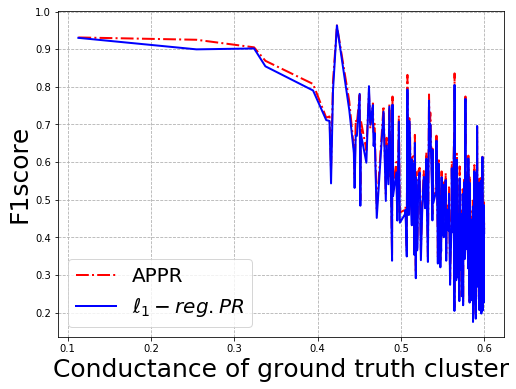

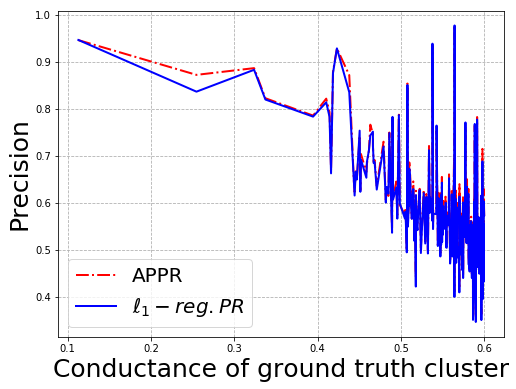

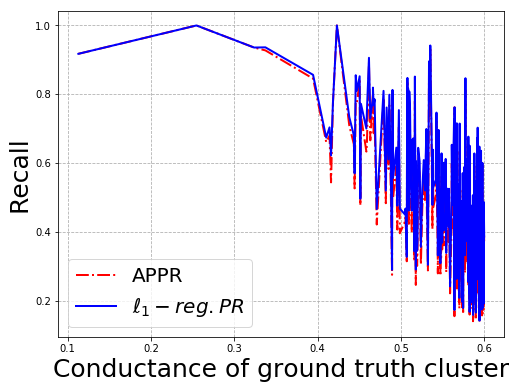

In [9]:
data = np.load('f1score_best_pre_acl_ORKUT.npy')
data2 = np.load('f1score_best_pre_l1reg_ORKUT_02.npy')

f1_acl = np.zeros(len(all_clusters))
f1_l1 = np.zeros(len(all_clusters))

conductance_all_cluster = np.zeros(len(all_clusters))

for key in data.item().keys():
    f1_acl[key[0]] += data.item().get(key)
    
for key in data2.item().keys():
    f1_l1[key[0]] += data2.item().get(key)
  
avg_f1_acl = np.zeros(len(all_clusters))
avg_f1_l1 = np.zeros(len(all_clusters))

for i in range(len(avg_f1_acl)):
    avg_f1_acl[i] = f1_acl[i]/len(all_clusters[i])
    
for i in range(len(avg_f1_l1)):
    avg_f1_l1[i] = f1_l1[i]/len(all_clusters[i])
    
for i in range(len(all_clusters)):
    conductance_all_cluster[i] = g.compute_conductance(all_clusters[i])
    
idx = np.argsort(conductance_all_cluster)

fig = plt.figure(figsize=(8, 6))
plt.plot(conductance_all_cluster[idx],avg_f1_acl[idx], label=("APPR"), linewidth=2.0, color ="red", linestyle="-.")

plt.plot(conductance_all_cluster[idx],avg_f1_l1[idx], label=("$\ell_1-reg. PR$"), linewidth=2.0, color ="blue")

plt.legend(prop={'size': 20},loc="lower left")
plt.xlabel("Conductance of ground truth cluster", fontsize=25)
plt.ylabel("F1score", fontsize=25)
plt.grid(linestyle='dashed')
plt.show()
fig.savefig('f1_orkut_appr_vs_l1.pdf')

data = np.load('precision_best_pre_acl_ORKUT.npy')
data2 = np.load('precision_best_pre_l1reg_ORKUT_2.npy')

pre_acl = np.zeros(len(all_clusters))
pre_l1 = np.zeros(len(all_clusters))

for key in data.item().keys():
    pre_acl[key[0]] += data.item().get(key)
    
for key in data2.item().keys():
    pre_l1[key[0]] += data2.item().get(key)
  
avg_pre_acl = np.zeros(len(all_clusters))
avg_pre_l1 = np.zeros(len(all_clusters))

for i in range(len(avg_pre_acl)):
    avg_pre_acl[i] = pre_acl[i]/len(all_clusters[i])
    
for i in range(len(avg_pre_l1)):
    avg_pre_l1[i] = pre_l1[i]/len(all_clusters[i])
   
fig = plt.figure(figsize=(8, 6))
plt.plot(conductance_all_cluster[idx],avg_pre_acl[idx], label=("APPR"), linewidth=2.0, color ="red", linestyle="-.")

plt.plot(conductance_all_cluster[idx],avg_pre_l1[idx], label=("$\ell_1-reg. PR$"), linewidth=2.0, color ="blue")

plt.legend(prop={'size': 20},loc="lower left")
plt.xlabel("Conductance of ground truth cluster", fontsize=25)
plt.ylabel("Precision", fontsize=25)
plt.grid(linestyle='dashed')
plt.show()
fig.savefig('pre_orkut_appr_vs_l1.pdf')

data = np.load('recall_best_pre_acl_ORKUT.npy')
data2 = np.load('recall_best_pre_l1reg_ORKUT_2.npy')

re_acl = np.zeros(len(all_clusters))
re_l1 = np.zeros(len(all_clusters))

for key in data.item().keys():
    re_acl[key[0]] += data.item().get(key)
    
for key in data2.item().keys():
    re_l1[key[0]] += data2.item().get(key)
  
avg_re_acl = np.zeros(len(all_clusters))
avg_re_l1 = np.zeros(len(all_clusters))

for i in range(len(avg_re_acl)):
    avg_re_acl[i] = re_acl[i]/len(all_clusters[i])
    
for i in range(len(avg_re_l1)):
    avg_re_l1[i] = re_l1[i]/len(all_clusters[i])
    
fig = plt.figure(figsize=(8, 6))
plt.plot(conductance_all_cluster[idx],avg_re_acl[idx], label=("APPR"), linewidth=2.0, color ="red", linestyle="-.")

plt.plot(conductance_all_cluster[idx],avg_re_l1[idx], label=("$\ell_1-reg. PR$"), linewidth=2.0, color ="blue")

plt.legend(prop={'size': 20},loc="lower left")
plt.xlabel("Conductance of ground truth cluster", fontsize=25)
plt.ylabel("Recall", fontsize=25)
plt.grid(linestyle='dashed')
fig.savefig('re_orkut_appr_vs_l1.pdf')



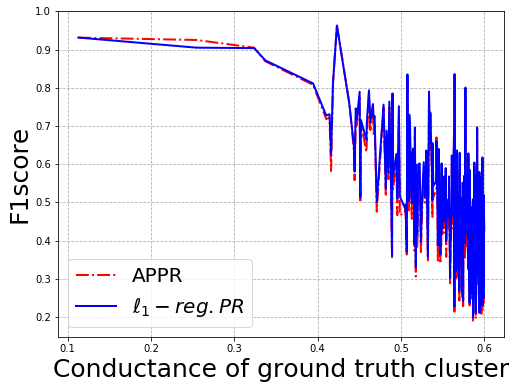

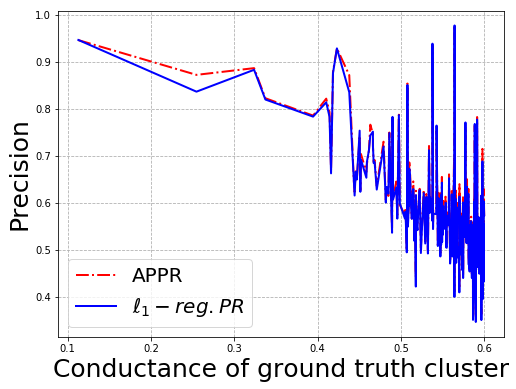

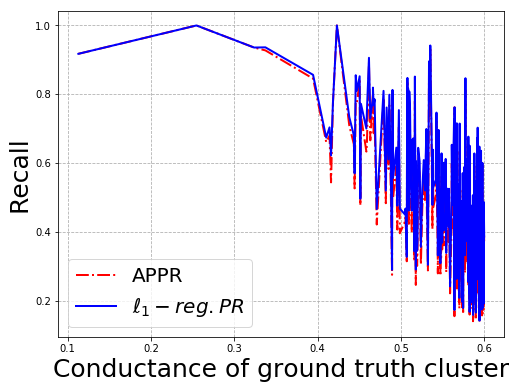

In [10]:
data = np.load('f1score_best_pre_acl_ORKUT.npy')
data2 = np.load('f1score_best_pre_l1reg_ORKUT_015.npy')

f1_acl = np.zeros(len(all_clusters))
f1_l1 = np.zeros(len(all_clusters))

conductance_all_cluster = np.zeros(len(all_clusters))

for key in data.item().keys():
    f1_acl[key[0]] += data.item().get(key)
    
for key in data2.item().keys():
    f1_l1[key[0]] += data2.item().get(key)
  
avg_f1_acl = np.zeros(len(all_clusters))
avg_f1_l1 = np.zeros(len(all_clusters))

for i in range(len(avg_f1_acl)):
    avg_f1_acl[i] = f1_acl[i]/len(all_clusters[i])
    
for i in range(len(avg_f1_l1)):
    avg_f1_l1[i] = f1_l1[i]/len(all_clusters[i])
    
for i in range(len(all_clusters)):
    conductance_all_cluster[i] = g.compute_conductance(all_clusters[i])
    
idx = np.argsort(conductance_all_cluster)

fig = plt.figure(figsize=(8, 6))
plt.plot(conductance_all_cluster[idx],avg_f1_acl[idx], label=("APPR"), linewidth=2.0, color ="red", linestyle="-.")

plt.plot(conductance_all_cluster[idx],avg_f1_l1[idx], label=("$\ell_1-reg. PR$"), linewidth=2.0, color ="blue")

plt.legend(prop={'size': 20},loc="lower left")
plt.xlabel("Conductance of ground truth cluster", fontsize=25)
plt.ylabel("F1score", fontsize=25)
plt.grid(linestyle='dashed')
plt.show()
fig.savefig('f1_orkut_appr_vs_l1_015.pdf')

data = np.load('precision_best_pre_acl_ORKUT.npy')
data2 = np.load('precision_best_pre_l1reg_ORKUT_015.npy')

pre_acl = np.zeros(len(all_clusters))
pre_l1 = np.zeros(len(all_clusters))

for key in data.item().keys():
    pre_acl[key[0]] += data.item().get(key)
    
for key in data2.item().keys():
    pre_l1[key[0]] += data2.item().get(key)
  
avg_pre_acl = np.zeros(len(all_clusters))
avg_pre_l1 = np.zeros(len(all_clusters))

for i in range(len(avg_pre_acl)):
    avg_pre_acl[i] = pre_acl[i]/len(all_clusters[i])
    
for i in range(len(avg_pre_l1)):
    avg_pre_l1[i] = pre_l1[i]/len(all_clusters[i])
   
fig = plt.figure(figsize=(8, 6))
plt.plot(conductance_all_cluster[idx],avg_pre_acl[idx], label=("APPR"), linewidth=2.0, color ="red", linestyle="-.")

plt.plot(conductance_all_cluster[idx],avg_pre_l1[idx], label=("$\ell_1-reg. PR$"), linewidth=2.0, color ="blue")

plt.legend(prop={'size': 20},loc="lower left")
plt.xlabel("Conductance of ground truth cluster", fontsize=25)
plt.ylabel("Precision", fontsize=25)
plt.grid(linestyle='dashed')
plt.show()
fig.savefig('pre_orkut_appr_vs_l1_015.pdf')

data = np.load('recall_best_pre_acl_ORKUT.npy')
data2 = np.load('recall_best_pre_l1reg_ORKUT_015.npy')

re_acl = np.zeros(len(all_clusters))
re_l1 = np.zeros(len(all_clusters))

for key in data.item().keys():
    re_acl[key[0]] += data.item().get(key)
    
for key in data2.item().keys():
    re_l1[key[0]] += data2.item().get(key)
  
avg_re_acl = np.zeros(len(all_clusters))
avg_re_l1 = np.zeros(len(all_clusters))

for i in range(len(avg_re_acl)):
    avg_re_acl[i] = re_acl[i]/len(all_clusters[i])
    
for i in range(len(avg_re_l1)):
    avg_re_l1[i] = re_l1[i]/len(all_clusters[i])
    
fig = plt.figure(figsize=(8, 6))
plt.plot(conductance_all_cluster[idx],avg_re_acl[idx], label=("APPR"), linewidth=2.0, color ="red", linestyle="-.")

plt.plot(conductance_all_cluster[idx],avg_re_l1[idx], label=("$\ell_1-reg. PR$"), linewidth=2.0, color ="blue")

plt.legend(prop={'size': 20},loc="lower left")
plt.xlabel("Conductance of ground truth cluster", fontsize=25)
plt.ylabel("Recall", fontsize=25)
plt.grid(linestyle='dashed')
fig.savefig('re_orkut_appr_vs_l1_015.pdf')




In [ ]:
text_file = open("statistical_guarantees_paper_ORKUT_experiments015.txt", "r")

overall_time_l1 = 0

lines = text_file.readlines()
for line in lines:
#     print(line)
    place = line.find("l1-reg. with rounding:")
    if place != -1:
        overall_time_l1 += float(line[place+22:place+33])
print("overall time for l1: ", overall_time_l1)

In [ ]:
text_file = open("statistical_guarantees_paper_ORKUT_experiments_old_keep.txt", "r")

overall_time_appr = 0

lines = text_file.readlines()
for line in lines:
#     print(line)
    place = line.find("ACL with rounding:")
    if place != -1:
        overall_time_appr += float(line[place+18:place+33])
print("overall time for APPR: ", overall_time_appr)